In [1]:
import torch
import torchvision
import cv2
from torchvision import transforms
from torch.utils.data import random_split
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
# torch.manual_seed(17)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)


# from google.colab import drive
# drive.mount('/content/drive')
# %cd drive/MyDrive/COMPUTER_VISION/PROJECT

c:\Users\goate\miniconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Impossibile trovare la procedura specificata'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


cpu


In [2]:
transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.PILToTensor(), #instead of to tensor
    transforms.ConvertImageDtype(torch.float32),
    transforms.Resize((64, 64))
])

In [3]:
'''
BATCH_SIZE = 32

trainset = torchvision.datasets.ImageFolder(root='CVPR2023_project_2_and_3_data/train/', transform=transform, loader=Image.open)

true_train_set, validation_train_set = random_split(trainset, (0.85, 0.15))

trainloader = torch.utils.data.DataLoader(true_train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True) # batch size of 1 because we have to crop in order to get all images to same size (64x64), also see pin_memory optin
validloader = torch.utils.data.DataLoader(validation_train_set, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

testset = torchvision.datasets.ImageFolder(root='CVPR2023_project_2_and_3_data/test/', transform=transform, loader=Image.open)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True) # batch size of 1 because we have to crop in order to get all images to same size (64x64), also see pin_memory optin

print(f'entire train folder: {len(trainset)}, entire test folder: {len(testset)}, splitted trainset: {len(true_train_set)},  splitted validset: {len(validation_train_set)}')
'''

"\nBATCH_SIZE = 32\n\ntrainset = torchvision.datasets.ImageFolder(root='CVPR2023_project_2_and_3_data/train/', transform=transform, loader=Image.open)\n\ntrue_train_set, validation_train_set = random_split(trainset, (0.85, 0.15))\n\ntrainloader = torch.utils.data.DataLoader(true_train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True) # batch size of 1 because we have to crop in order to get all images to same size (64x64), also see pin_memory optin\nvalidloader = torch.utils.data.DataLoader(validation_train_set, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)\n\ntestset = torchvision.datasets.ImageFolder(root='CVPR2023_project_2_and_3_data/test/', transform=transform, loader=Image.open)\ntestloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True) # batch size of 1 because we have to crop in order to get all images to same size (64x64), also see pin_memory optin\n\nprint(f'entire train folder: {len(trainset)}, entire test fold

In [4]:
BATCH_SIZE = 32

# open_image = lambda img: cv2.imread(filename=img, flags=cv2.IMREAD_GRAYSCALE)

trainset = torchvision.datasets.ImageFolder(root='CVPR2023_project_2_and_3_data/train/', transform=transform, loader=Image.open)

true_train_set, validation_train_set = random_split(trainset, (0.85, 0.15))

trainloader = torch.utils.data.DataLoader(true_train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True) # batch size of 1 because we have to crop in order to get all images to same size (64x64), also see pin_memory optin
validloader = torch.utils.data.DataLoader(validation_train_set, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

testset = torchvision.datasets.ImageFolder(root='CVPR2023_project_2_and_3_data/test/', transform=transform, loader=Image.open)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True) # batch size of 1 because we have to crop in order to get all images to same size (64x64), also see pin_memory optin

print(f'entire train folder: {len(trainset)}, entire test folder: {len(testset)}, splitted trainset: {len(true_train_set)},  splitted validset: {len(validation_train_set)}')

entire train folder: 1500, entire test folder: 2985, splitted trainset: 1275,  splitted validset: 225


In [5]:
'''
# abbiamo verificato che su un'altro dataset (MNIST) il training funzionasse
transforms = torchvision.transforms.Compose([
        # transforms.Resize((64, 64)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

trainset = torchvision.datasets.MNIST('.', transform=transforms,  train=True, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.MNIST('.', transform=transforms, train=False, download=True)
validloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)
'''

"\n# abbiamo verificato che su un'altro dataset (MNIST) il training funzionasse\ntransforms = torchvision.transforms.Compose([\n        # transforms.Resize((64, 64)),\n        torchvision.transforms.ToTensor(),\n        torchvision.transforms.Normalize((0.1307,), (0.3081,))\n])\n\ntrainset = torchvision.datasets.MNIST('.', transform=transforms,  train=True, download=True)\ntrainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)\n\ntestset = torchvision.datasets.MNIST('.', transform=transforms, train=False, download=True)\nvalidloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)\n"

In [6]:
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=2, stride=2),
                torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=2, stride=2),
                torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1),
                torch.nn.ReLU()
        )
        
        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(32*12*12, 15)
        )

    def forward(self, x):
        return self.classifier(self.conv(x))


model = CNN().to(device)

In [7]:
def initialize_weigths_and_bias(m):
  if (type(m) == torch.nn.Linear) or (type(m) == torch.nn.Conv2d):
      torch.nn.init.constant_(m.bias.data, 0) # initialize weights
      torch.nn.init.normal_(m.weight.data, mean=0.0, std=0.01)
  

model.apply(initialize_weigths_and_bias)

CNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4608, out_features=15, bias=True)
  )
)

In [8]:
# The same plotting function from the previous lab
def imshow(img):
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

c:\Users\goate\miniconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


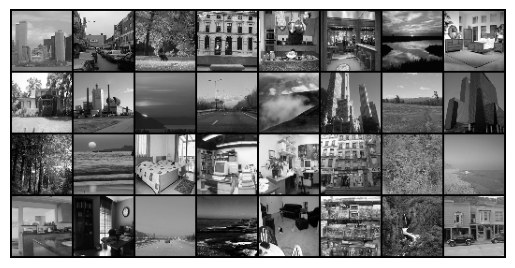

In [9]:
images, labels = next(iter(trainloader))

imshow(torchvision.utils.make_grid(images))

In [10]:
# Checking initialization printing mean, std, max biases in the classifier fully connected layer

model.classifier[1].weight.mean(), model.classifier[1].weight.std(), model.classifier[1].bias.max()

(tensor(-1.5399e-05, grad_fn=<MeanBackward0>),
 tensor(0.0099, grad_fn=<StdBackward0>),
 tensor(0., grad_fn=<MaxBackward1>))

In [11]:
# Checking initialization printing mean, std, max biases in the first convolution layer

model.conv[3].weight.mean(), model.conv[3].weight.std(), model.conv[3].bias.max()

(tensor(0.0002, grad_fn=<MeanBackward0>),
 tensor(0.0102, grad_fn=<StdBackward0>),
 tensor(0., grad_fn=<MaxBackward1>))

In [12]:
def get_accuracy(model, dataloader):
    model.eval()
    with torch.no_grad():
        correct=0
        for x, y in iter(dataloader):
            x = x.to(device)
            y = y.to(device)
            out=model(x)
            correct+=(torch.argmax(out, axis=1)==y).sum()
        return correct/len(dataloader.dataset)

In [13]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss = torch.nn.CrossEntropyLoss()

In [14]:
epochs = 5
losses = []
flag = False
for epoch in range(epochs):
    print(f"Epoch: {epoch}, Test accuracy: {get_accuracy(model, validloader)}")
    model.train()
    running_loss = 0
    for x, y in iter(trainloader):
        x = x.to(device)
        y = y.to(device)
        out=model(x)
        l=loss(out, y)
        running_loss += l.item()
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    losses.append(running_loss/len(trainloader.dataset))
print(f"Final accuracy: {get_accuracy(model, validloader)}")

c:\Users\goate\miniconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 0, Test accuracy: 0.07111111283302307
Epoch: 1, Test accuracy: 0.0533333346247673
Epoch: 2, Test accuracy: 0.04888888821005821
Epoch: 3, Test accuracy: 0.04888888821005821
Epoch: 4, Test accuracy: 0.04888888821005821
Final accuracy: 0.04888888821005821


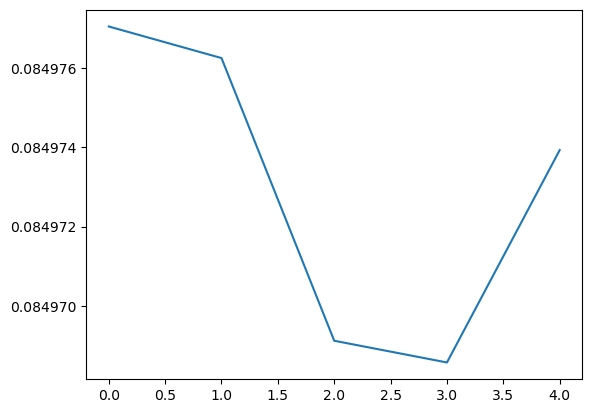

In [15]:
plt.plot(losses)